In [1]:
import os
import h5py
import pandas as pd
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from random import randint
from random import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
plt.ion()   # interactive mode

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data loading and processing

In [2]:
PATH = "datasets/"
trainHdf5 = f'{PATH}Chong_train_set.hdf5'
traindata = h5py.File(trainHdf5, 'r')
valHdf5 = f'{PATH}Chong_valid_set.hdf5'
valdata = h5py.File(valHdf5, 'r')
testHdf5 = f'{PATH}Chong_test_set.hdf5'
testdata = h5py.File(testHdf5, 'r')

In [3]:
idx_classes = sorted(list(set([y.decode("utf-8") for y in traindata['label_names']])))
idx_to_class = {idx_classes.index(x):x  for x in idx_classes}

In [4]:
class ChongSet(Dataset):
    
    def __init__(self, hdf5, transform=None):
        classes = sorted(list(set([y for y in hdf5['label_names']])))
        class_to_idx = {x: classes.index(x) for x in classes}
        
        imgs = hdf5['data1']
        labels = hdf5['label_names']
        self.transform = transform
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.imgs = imgs
        self.labels = labels
        self.data = []
        
        for i in range(len(imgs)):
            tmp = (np.array(imgs[i,:]).reshape(2,64,64).T, labels[i])
            self.data.append(tmp)
  
        
    def __len__(self):
        return(self.imgs.shape[0])
    
    def __getitem__(self, idx):
               
        img, cls = self.data[idx]
        cls = self.class_to_idx[cls]

        if self.transform:
            img = self.transform(img)
       
        return(img, cls)

In [5]:
def randomsequence():
    
    class RandomCrop(object):
        """Crop randomly the image in a sample.

        Args:
            output_size (tuple or int): Desired output size. If int, square crop
                is made.
        """

        def __init__(self, output_size):
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                self.output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                self.output_size = output_size

        def __call__(self, sample):
            image= sample

            h, w = image.shape[:2]
            new_h, new_w = self.output_size

            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h,
                          left: left + new_w]

            return image


    class FlipLeftRight(object):

        def __call__(self, sample):
            image= sample
            #h,w,c = image.shape
            if random.random() < 0.5:
                return(np.flip(image, 0).copy())
            else:
                return(image)

    class UpLeftDown(object):

        def __call__(self, sample):
            image= sample
            #h,w,c = image.shape
            if random.random() < 0.5:
                return(np.flip(image, 1).copy())
            else:
                return(image)

    class RandomRotate(object):

        def __call__(self, sample):
            image = sample
            u = randint(0,3)
            return(np.rot90(image, u, (0,1)).copy())

    class RandomMultiply(object):
        def __init__(self, low, high):
            self.multiply = random.uniform(low, high)
        def __call__(self, sample):
            image=sample
            return(np.multiply(image, self.multiply).copy())
    
    
    functions = list([RandomCrop(60),
        FlipLeftRight(),
        UpLeftDown(),
        RandomRotate(),
        RandomMultiply(0.8, 1.2)]),
    shuffle(functions)
    functions = functions[0]
    functions.append(transforms.ToTensor())
    functions.append(transforms.Normalize([0.5,0.5],[0.5,0.5]))
    return(functions)

In [6]:
data_transforms = {
    'train': transforms.Compose(randomsequence()),
    'val':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5], [0.5, 0.5])
    ]),
    'test':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5], [0.5, 0.5])
    ]),
}

In [7]:
image_datasets = {'train': ChongSet(traindata, transform = data_transforms['train'] ), 'val': ChongSet(valdata, transform = data_transforms['val']), 'test': ChongSet(testdata, transform = data_transforms['test'])}
image_datasets

{'test': <__main__.ChongSet at 0x7f14fc6f1940>,
 'train': <__main__.ChongSet at 0x7f14fc6f6438>,
 'val': <__main__.ChongSet at 0x7f14fc6a7630>}

In [8]:
dataloaders = {'train':torch.utils.data.DataLoader(image_datasets['train'], batch_size=128, shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, shuffle=False, num_workers=4),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=16, shuffle=False,num_workers=4)}
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f14fbe867f0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f14fbe866a0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f14fbe86748>}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

{'test': 4516, 'train': 21882, 'val': 4491}

In [10]:
use_gpu = torch.cuda.is_available()
use_gpu

True

## Load model

In [11]:
class Deeploc(nn.Module):
    def __init__(self):
        super(Deeploc, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding =1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding = 1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding =1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 1)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(256),
            nn.ReLU() 
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*8*256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.logit = nn.Linear(512, 19)

        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(-1, 8*8*256)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.logit(x)
        
        return F.sigmoid(x)

In [12]:
model = Deeploc()

## Train and validate functions

In [13]:
def get_multilabel_accuracy(pred, target):
    pred = pred > 0.4
    comp = torch.sum(torch.abs(pred.long() - target.long()).long(), dim=1)
    acc = pred.size()[0] - len(torch.nonzero(comp))
    return(acc/(pred.size()[0]))

In [14]:
def get_element_accuracy(pred, target):
    pred = pred > 0.4
    r = (pred == target.byte())
    acc = r.float().cpu().sum().data[0]
    return acc/(pred.size()[1]*pred.size()[0])

In [15]:
def train(model, loader, criterion, optimizer, scheduler, verbose=False):
    #scheduler.step()
    model.train()
    running_loss=0
    running_accuracy=0
    element_accuracy =0
    for i, (X, y) in enumerate(loader):
        y = torch.from_numpy(np.eye(19)[y]).float()
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = 50*criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        acc = get_multilabel_accuracy(output, y)
        acce = get_element_accuracy(output, y)
        running_accuracy += acc
        element_accuracy += acce
        if i%400 == 0 and verbose:
            pct = float(i+1)/len(loader)
            curr_loss = running_loss/(i+1)
            curr_acc = running_accuracy/(i+1)
            print('Complete:{:.2f}, loss:{:.2f}, Accuracy:{:.4f}'.format(pct*100, curr_loss, curr_acc))
    return(running_loss/len(loader),element_accuracy/len(loader),running_accuracy/len(loader))

In [16]:
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    running_accuracy = 0
    element_accuracy =0
    targets = torch.FloatTensor(0, 19)
    predictions = torch.FloatTensor(0, 19)
    for i, (X, y) in enumerate(loader):
        y = torch.from_numpy(np.eye(19)[y]).float()
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X, volatile=True), Variable(y)
        output = model(X)
        loss = 50*criterion(output, y)
        acc = get_multilabel_accuracy(output, y)
        acce = get_element_accuracy(output, y)
        targets = torch.cat((targets, y.cpu().data), 0)
        predictions = torch.cat((predictions, output.cpu().data), 0)
        running_loss += loss.data[0]
        running_accuracy += acc
        element_accuracy += acce
    fscore = fbeta_score(targets.numpy(), predictions.numpy() > 0.4, beta=2, average = 'samples')
    return(running_loss/len(loader), element_accuracy/len(loader), running_accuracy/len(loader), fscore)
    

In [17]:
criterion = torch.nn.BCELoss()
if use_gpu:
    model, criterion = model.cuda(), criterion.cuda()

In [18]:
model.load_state_dict(torch.load('DeepLocML5.pth'))

In [19]:
patience = 5
best_loss = 1e4

In [20]:
optimizer = optim.Adam(model.parameters(), lr = 0.05)
#optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [21]:
from sklearn.metrics import fbeta_score

In [23]:
for e in range(100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    start = time.time()
    train_loss, train_acce,train_acc = train(model, dataloaders['train'], criterion, optimizer, scheduler, verbose = False)
    val_loss, val_acce, val_acc, fscore = validate(model, dataloaders['val'], criterion)
    scheduler.step(val_acc, 'max')
    end = time.time()
    
    stats = """Epoch: {}\t train loss: {:.3f}, train acc: {:.3f}, actual acc: {:.3f}\t
                val loss: {:.3f}, val acc: {:.3f}, actual acc: {:.3f}\t fscore: {:.3f}\t
                time: {:.1f}s""".format( e, train_loss, train_acce, train_acc, val_loss, val_acce, val_acc, fscore, end-start)
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print(stats)

Epoch: 0	 train loss: 0.774, train acc: 0.994, actual acc: 0.926	
                val loss: 1.332, val acc: 0.992, actual acc: 0.906	 fscore: 0.920	
                time: 46.6s


/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Epoch: 1	 train loss: 0.795, train acc: 0.994, actual acc: 0.924	
                val loss: 1.173, val acc: 0.992, actual acc: 0.913	 fscore: 0.928	
                time: 46.7s
Epoch: 2	 train loss: 0.813, train acc: 0.994, actual acc: 0.924	
                val loss: 1.529, val acc: 0.991, actual acc: 0.890	 fscore: 0.910	
                time: 46.7s
Epoch: 3	 train loss: 0.803, train acc: 0.994, actual acc: 0.925	
                val loss: 1.475, val acc: 0.990, actual acc: 0.888	 fscore: 0.911	
                time: 46.8s
Epoch: 4	 train loss: 0.788, train acc: 0.994, actual acc: 0.927	
                val loss: 0.961, val acc: 0.994, actual acc: 0.932	 fscore: 0.943	
                time: 46.7s
Epoch: 5	 train loss: 0.749, train acc: 0.994, actual acc: 0.930	
                val loss: 1.263, val acc: 0.992, actual acc: 0.911	 fscore: 0.929	
                time: 46.8s
Epoch: 6	 train loss: 0.749, train acc: 0.995, actual acc: 0.932	
                val loss: 1.520, val acc: 0.991, 

Epoch: 48	 train loss: 0.295, train acc: 0.998, actual acc: 0.971	
                val loss: 0.908, val acc: 0.995, actual acc: 0.941	 fscore: 0.951	
                time: 46.7s
Epoch: 49	 train loss: 0.310, train acc: 0.998, actual acc: 0.971	
                val loss: 0.917, val acc: 0.995, actual acc: 0.941	 fscore: 0.952	
                time: 46.7s
Epoch: 50	 train loss: 0.297, train acc: 0.998, actual acc: 0.970	
                val loss: 0.915, val acc: 0.995, actual acc: 0.940	 fscore: 0.951	
                time: 46.6s
Epoch: 51	 train loss: 0.311, train acc: 0.998, actual acc: 0.970	
                val loss: 0.892, val acc: 0.995, actual acc: 0.941	 fscore: 0.952	
                time: 46.6s
Epoch: 52	 train loss: 0.289, train acc: 0.998, actual acc: 0.971	
                val loss: 0.916, val acc: 0.995, actual acc: 0.941	 fscore: 0.952	
                time: 46.6s
Epoch: 53	 train loss: 0.313, train acc: 0.998, actual acc: 0.970	
                val loss: 0.914, val acc: 0

Epoch: 95	 train loss: 0.297, train acc: 0.998, actual acc: 0.971	
                val loss: 0.915, val acc: 0.995, actual acc: 0.939	 fscore: 0.951	
                time: 46.7s
Epoch: 96	 train loss: 0.297, train acc: 0.998, actual acc: 0.971	
                val loss: 0.921, val acc: 0.995, actual acc: 0.938	 fscore: 0.950	
                time: 46.7s
Epoch: 97	 train loss: 0.289, train acc: 0.998, actual acc: 0.971	
                val loss: 0.921, val acc: 0.995, actual acc: 0.940	 fscore: 0.951	
                time: 46.7s
Epoch: 98	 train loss: 0.300, train acc: 0.998, actual acc: 0.971	
                val loss: 0.900, val acc: 0.995, actual acc: 0.941	 fscore: 0.952	
                time: 46.7s
Epoch: 99	 train loss: 0.289, train acc: 0.998, actual acc: 0.972	
                val loss: 0.888, val acc: 0.995, actual acc: 0.942	 fscore: 0.952	
                time: 46.7s


In [34]:
torch.save(model.state_dict(), 'DeepLocML6.pth')

## Test data

In [13]:
model.load_state_dict(torch.load('DeepLocML6.pth'))

In [14]:
model = model.cuda()

In [15]:
def duplicate(i_pred):
    from collections import Counter
    return([item for item, count in Counter(i_pred).items() if count > 1])

In [16]:
def missing(L, start, end):
    return sorted(set(range(start, end)).difference(L))

In [17]:
def compare(i_pred, j_pred, end):

    pred_n = np.zeros((end))
    #missing
    miss_items = missing(i_pred, 0, end)
    # duplicate
    dup_items = duplicate(i_pred)
    for i in list(range(0,end)):
        if i in miss_items:
            pred_n[i] = 20
        elif i in dup_items:
            pred_n[i] = 21
        else:
            t, = np.where(i_pred==i)
            pred_n[i] = j_pred[t[0]]
    return(pred_n)

In [21]:
def pred_analysis(dataset, actual, predict):
    for i, (X, y) in enumerate(dataset):
        if use_gpu:
            X= X.cuda()
        X = Variable(X)
        outputs = model(X)
        outputs = outputs.cpu()
        y2 = torch.from_numpy(np.eye(19)[y]).float()
        y2 = Variable(y2)
        #acc = get_multilabel_accuracy(outputs, y2)
        preds = outputs>0.4
        #preds= preds.data.numpy()
        y = y.numpy()  
        end = len(y)
        i_pred,j_pred = np.where(preds.data==1)
        pred_n = compare(i_pred, j_pred, end)
        actual = np.append(actual, y)
        predict = np.append(predict, pred_n)
    return(actual, predict)

In [19]:
def calculate_cf_matrix(dataset):
    from sklearn.metrics import confusion_matrix
    actual = np.array([])
    predict = np.array([])
    actual, predict = pred_analysis(dataset, actual, predict)
    cf_matrix = confusion_matrix(list(actual), list(predict))
    cf_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    return(cf_matrix, cf_norm)

In [22]:
cf_matrix, cf_norm = calculate_cf_matrix(dataloaders['test'])

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


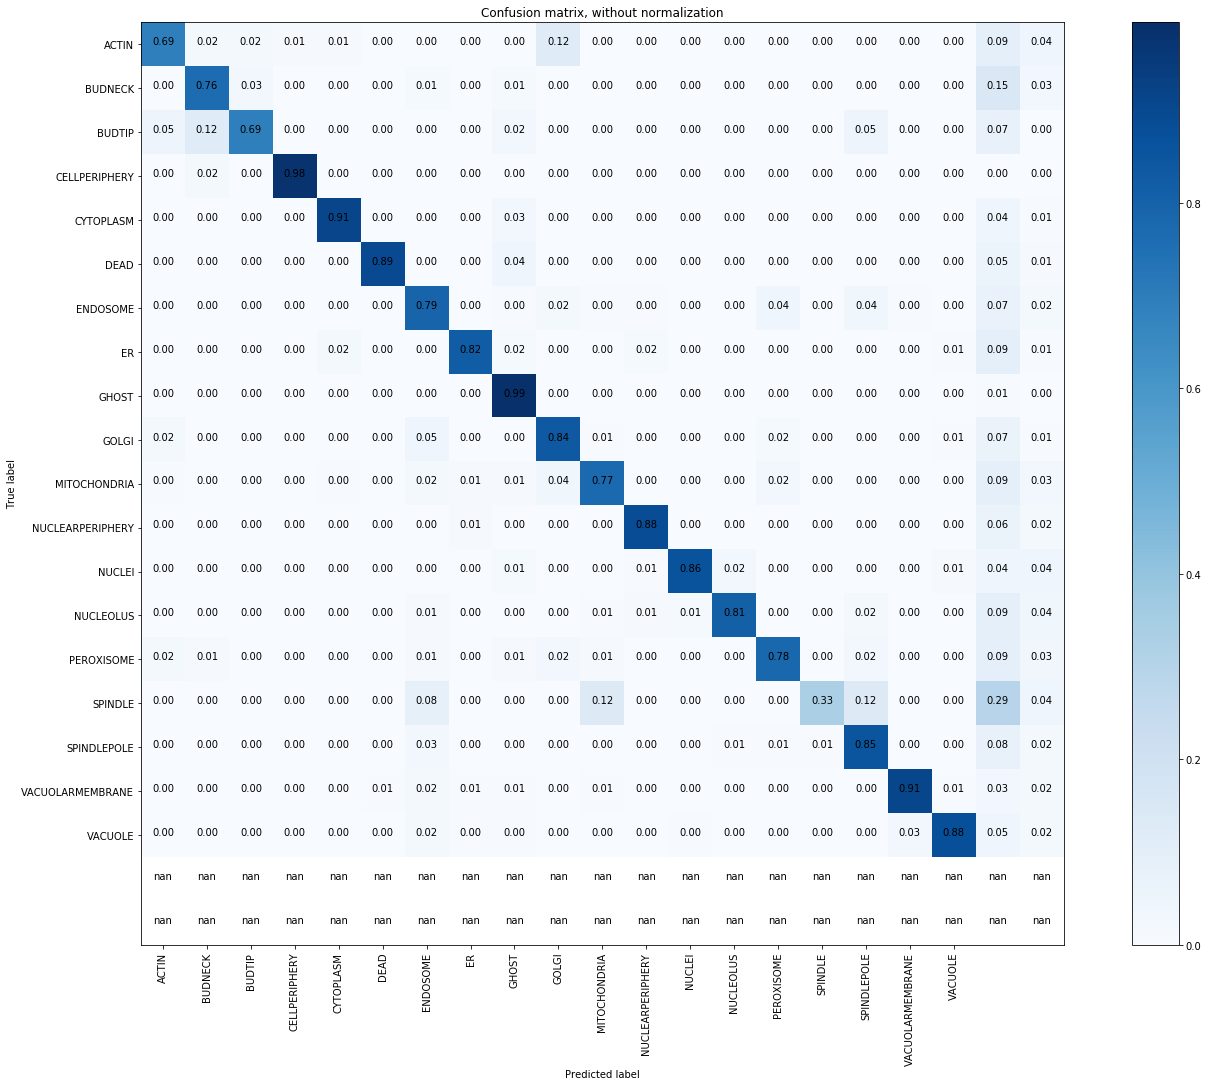

In [25]:
plt.figure(figsize=(20, 15))
plot_confusion_matrix(cf_norm, classes=idx_classes, normalize= True,
                      title='Confusion matrix, without normalization')
plt.show()

In [26]:
def bar_chart(cm_norm, classes):
    rates = cm_norm.diagonal()
    objects = classes
    y_pos = np.arange(len(objects))
    performance = rates
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation = 90)
    plt.ylabel('Performance')
    plt.title('Prediction performance')

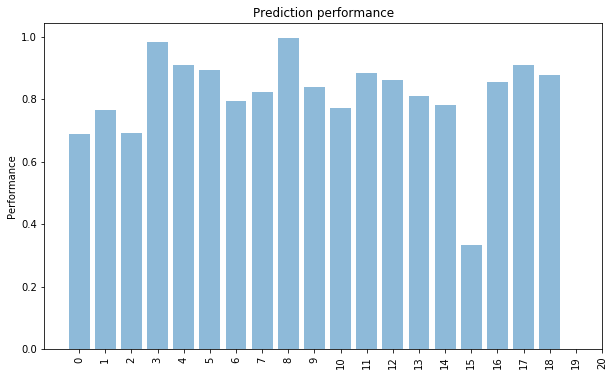

In [29]:
plt.figure(figsize=(10,6))
bar_chart(cf_norm, list(range(21)))
plt.show()